In [1]:
from pedpy import load_trajectory
from pedpy import (
    Geometry,
    TrajectoryUnit,
    get_invalid_trajectory,
    is_trajectory_valid,
)
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon
import warnings

warnings.filterwarnings("ignore")

# Setup geometry & measurement area

## Prepare geometry

In [2]:
geometry_poly = Polygon([(-10, -3), (-10, 8), (10, 8), (10, -3)])

geometry = Geometry(walkable_area=geometry_poly)
geometry.add_obstacle(Polygon([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry.add_obstacle(Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

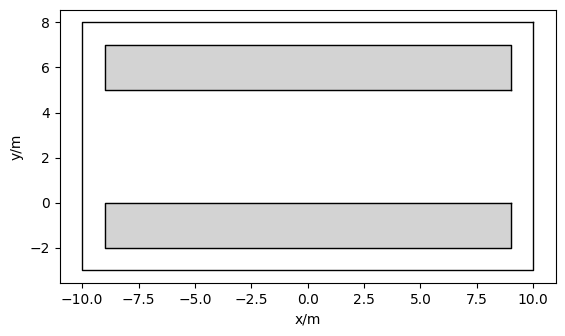

In [3]:
from pedpy.plotting.plotting import plot_geometry

plot_geometry(geometry=geometry, hole_color="lightgrey").set_aspect("equal")

## Prepare measurement details

In [4]:
ma = Polygon([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = LineString([(0, 0), (0, 5)])
passing_offset = 1.0

direction = np.array([-1, 0])

## Load trajectories

In [5]:
traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "demos/uni-directional/traj_UNI_CORR_500_01.txt"
    ),
    default_unit=TrajectoryUnit.METER,
    # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

## Plot setup

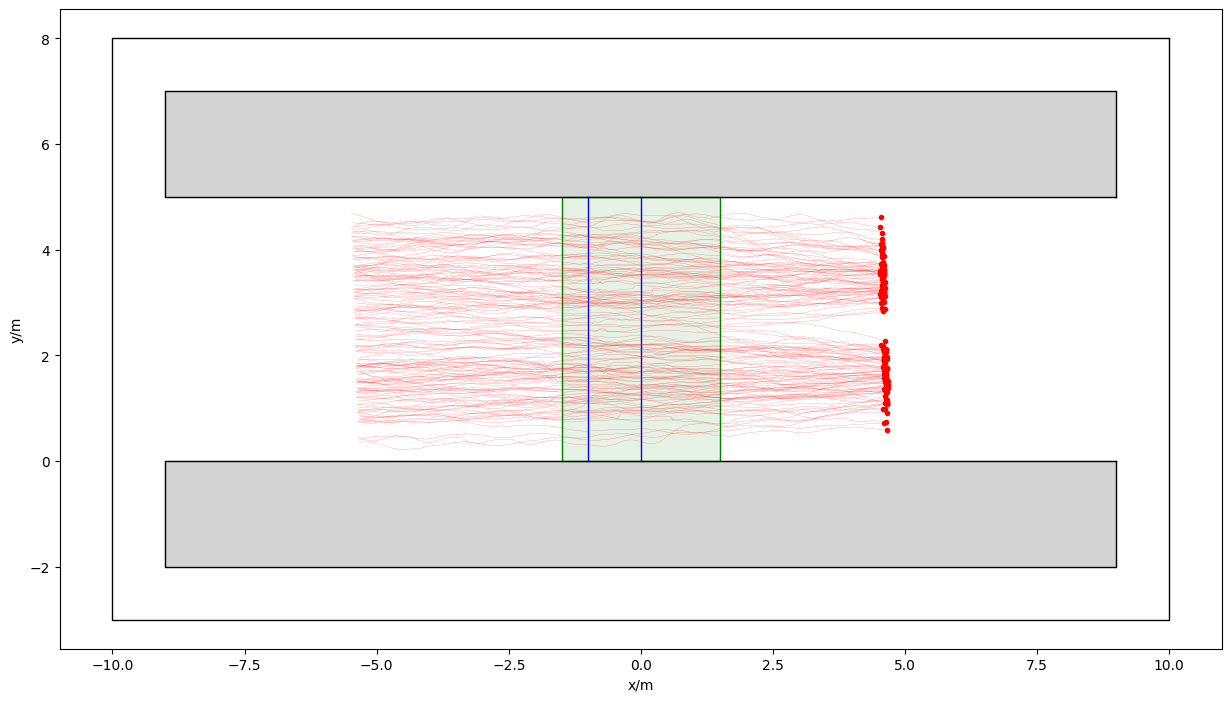

In [6]:
from pedpy import plot_measurement_setup

fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=traj,
    geometry=geometry,
    measurement_areas=[ma],
    measurement_lines=[ml, shapely.offset_curve(ml, passing_offset)],
    traj_width=0.1,
    traj_start_marker=".",
    hole_color="lightgrey",
    ml_color="b",
    ma_color="g",
    ma_alpha=0.1,
    ma_line_color="g",
    ax=ax1,
)
plt.show()

# Velocity

## Compare different movement methods

"""    The movement is computed for the interval [frame - frame_step: frame +
    frame_step], if one of the boundaries is not contained in the trajectory
    frame will be used as boundary. Hence, the intervals become [frame,
    frame + frame_step], or [frame - frame_step, frame] respectively.
"""

In [7]:
from pedpy import VelocityBorderMethod
from pedpy.methods.method_utils import _compute_individual_movement

frame_step = 5

In [8]:
current = _compute_individual_movement(
    traj_data=traj.data,
    frame_step=frame_step,
    border_method=VelocityBorderMethod.SINGLE_SIDED,
)

In [9]:
cutting = _compute_individual_movement(
    traj_data=traj.data,
    frame_step=frame_step,
    border_method=VelocityBorderMethod.EXCLUDE,
)

In [10]:
mixed = _compute_individual_movement(
    traj_data=traj.data,
    frame_step=frame_step,
    border_method=VelocityBorderMethod.MAXIMUM_RANGE,
)

In [11]:
adaptive = _compute_individual_movement(
    traj_data=traj.data,
    frame_step=frame_step,
    border_method=VelocityBorderMethod.ADAPTIVE,
)

### Compute speed

In [12]:
from pedpy.methods.velocity_calculator import _compute_individual_speed

adaptive_speed = _compute_individual_speed(
    movement_data=adaptive, frame_rate=traj.frame_rate
).dropna()

cutting_speed = _compute_individual_speed(
    movement_data=cutting, frame_rate=traj.frame_rate
)

current_speed = _compute_individual_speed(
    movement_data=current, frame_rate=traj.frame_rate
)

mixed_speed = _compute_individual_speed(
    movement_data=mixed, frame_rate=traj.frame_rate
)

### Plots

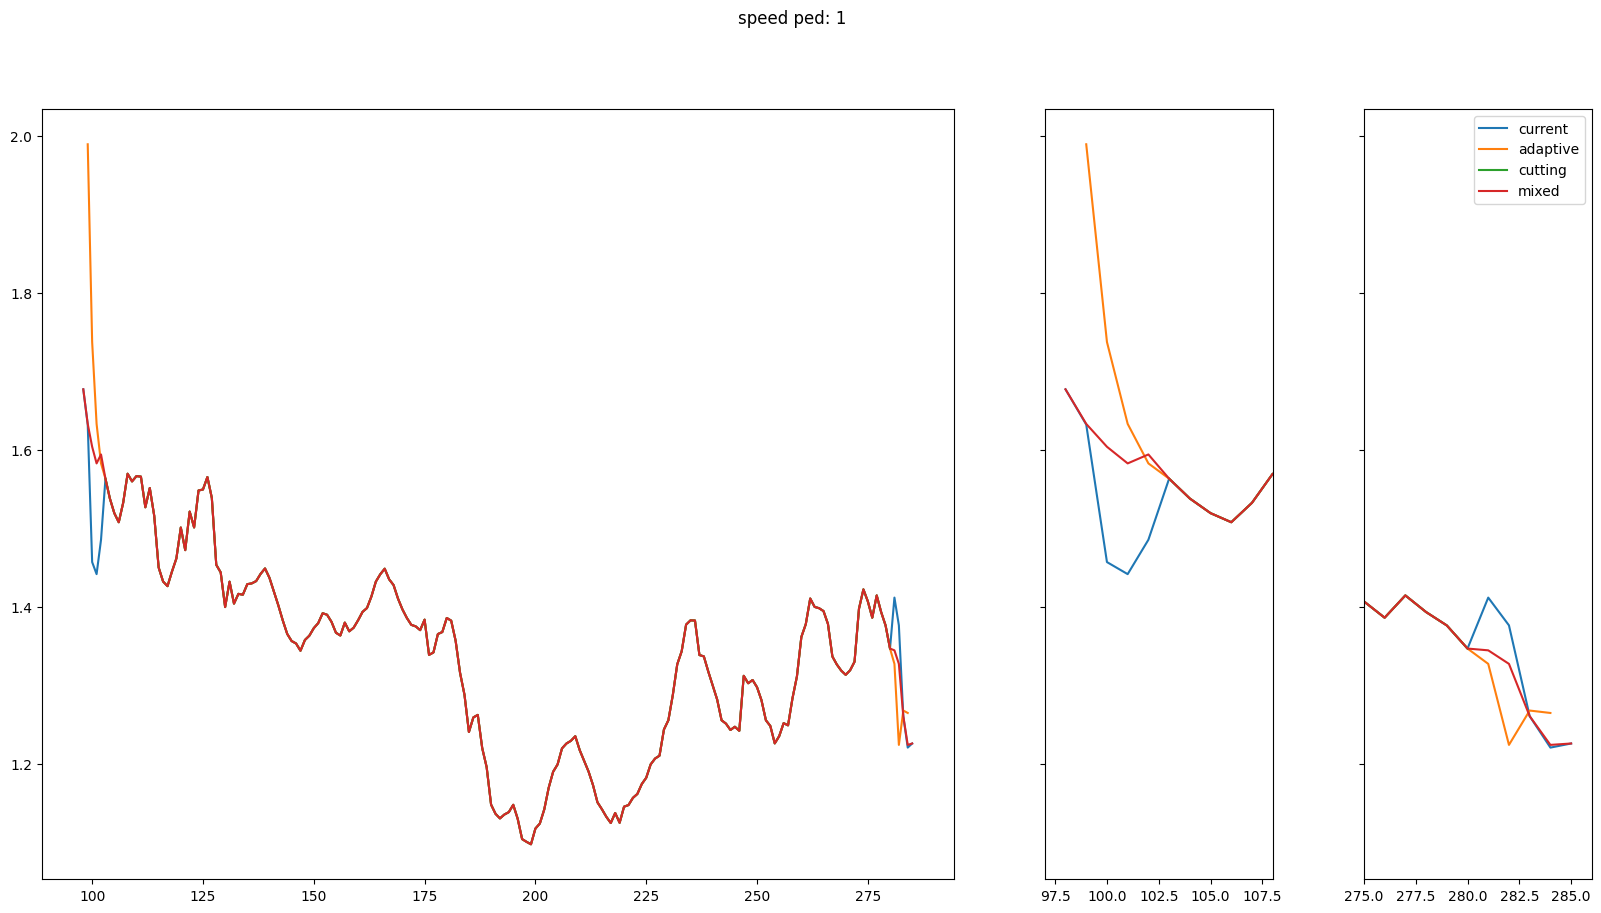

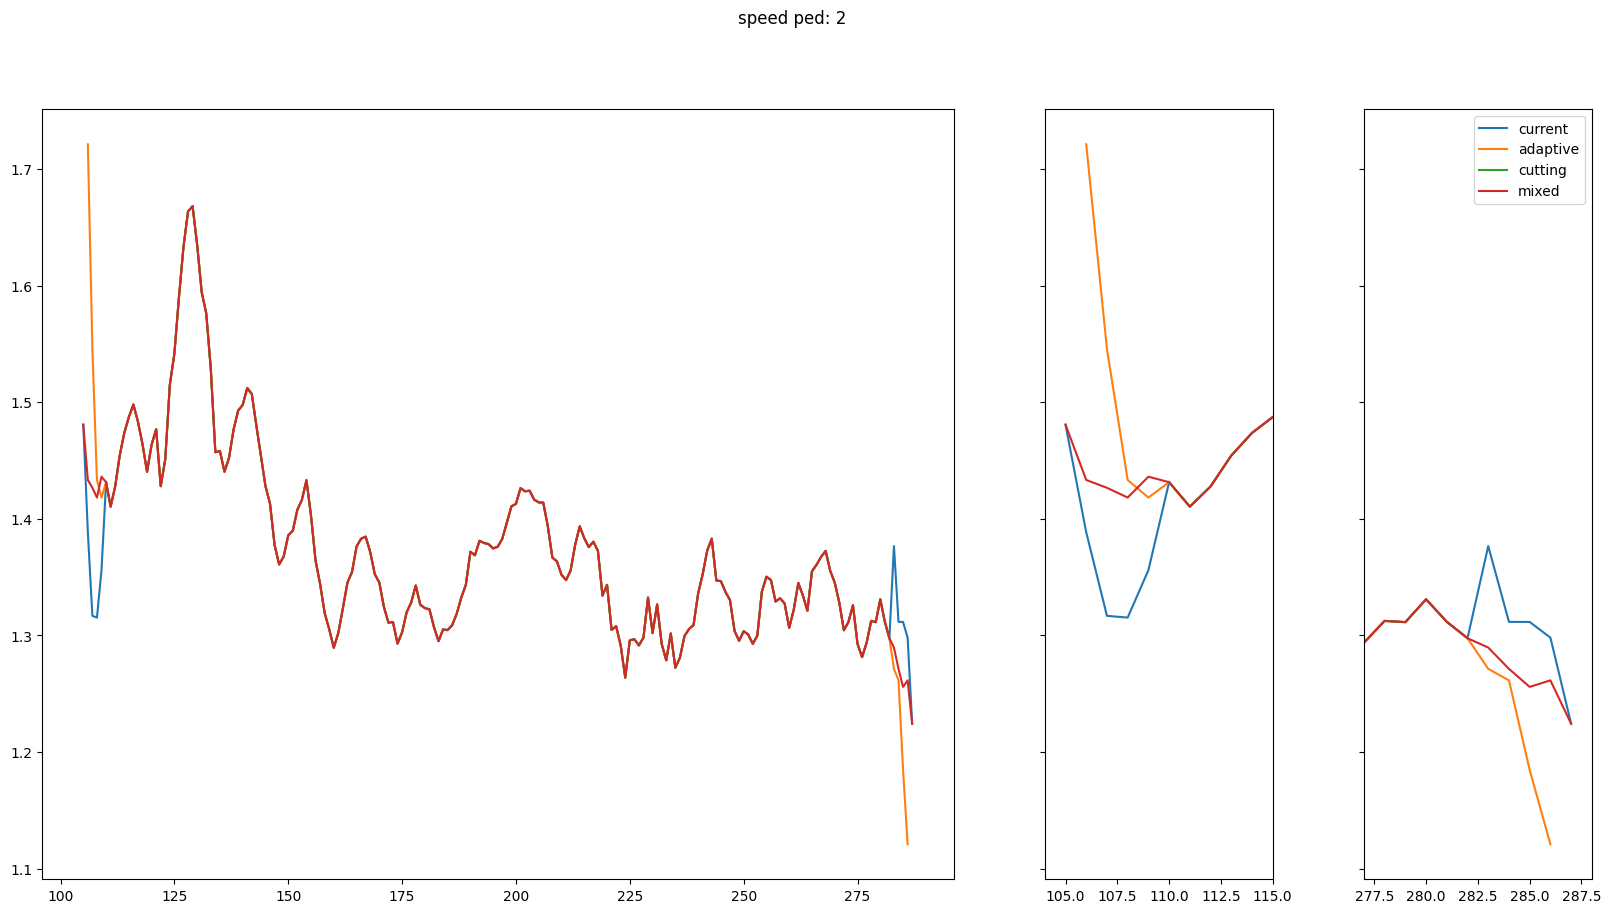

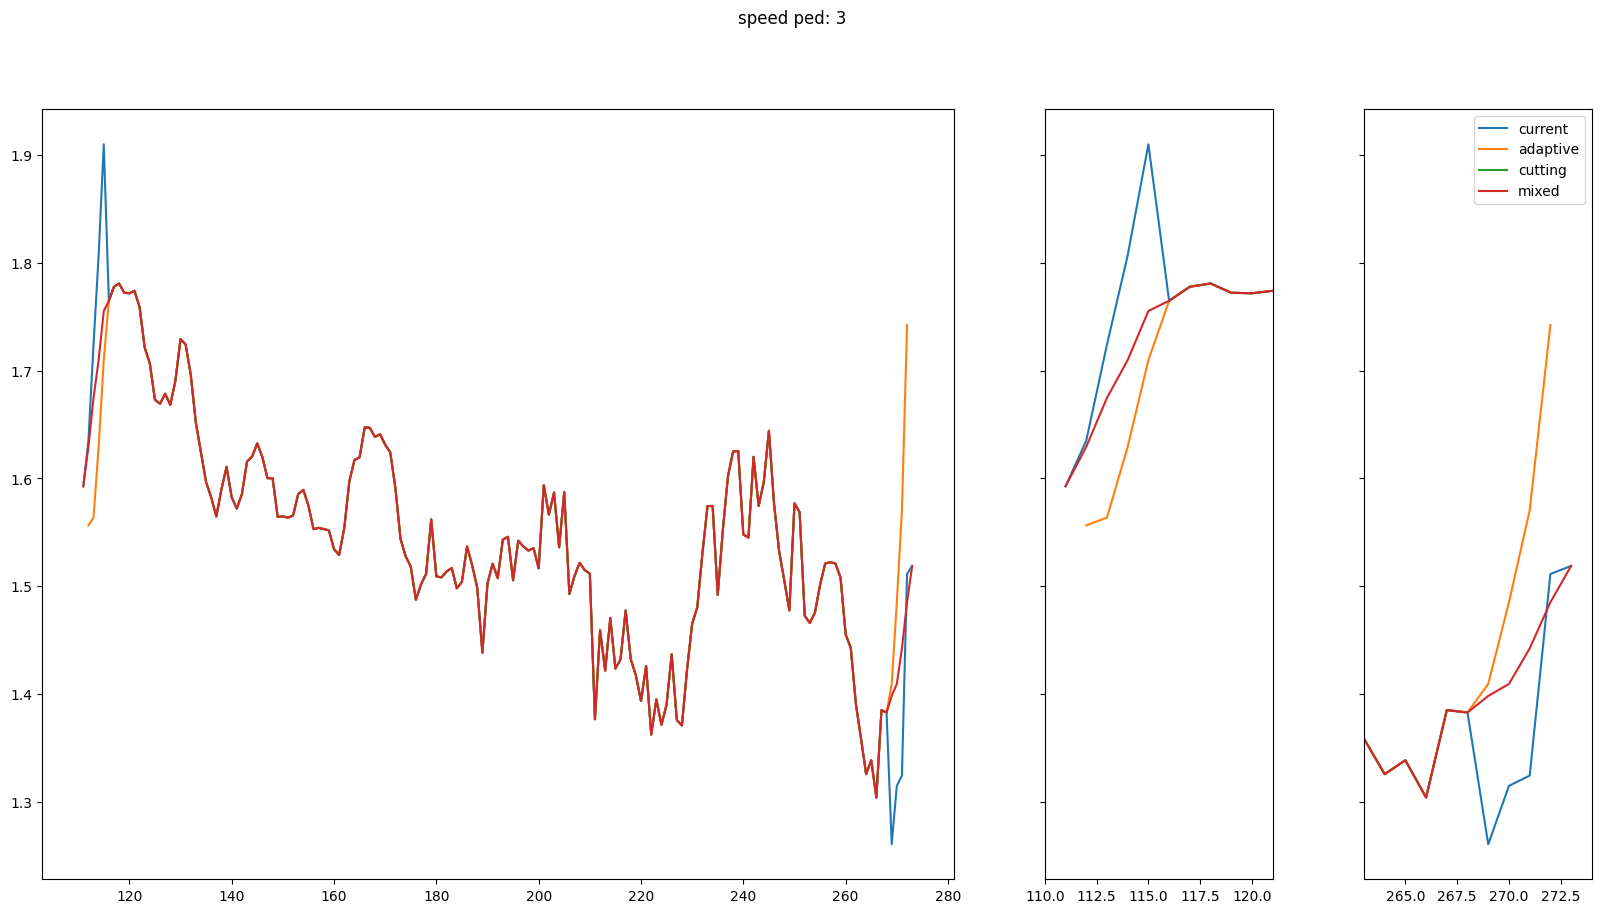

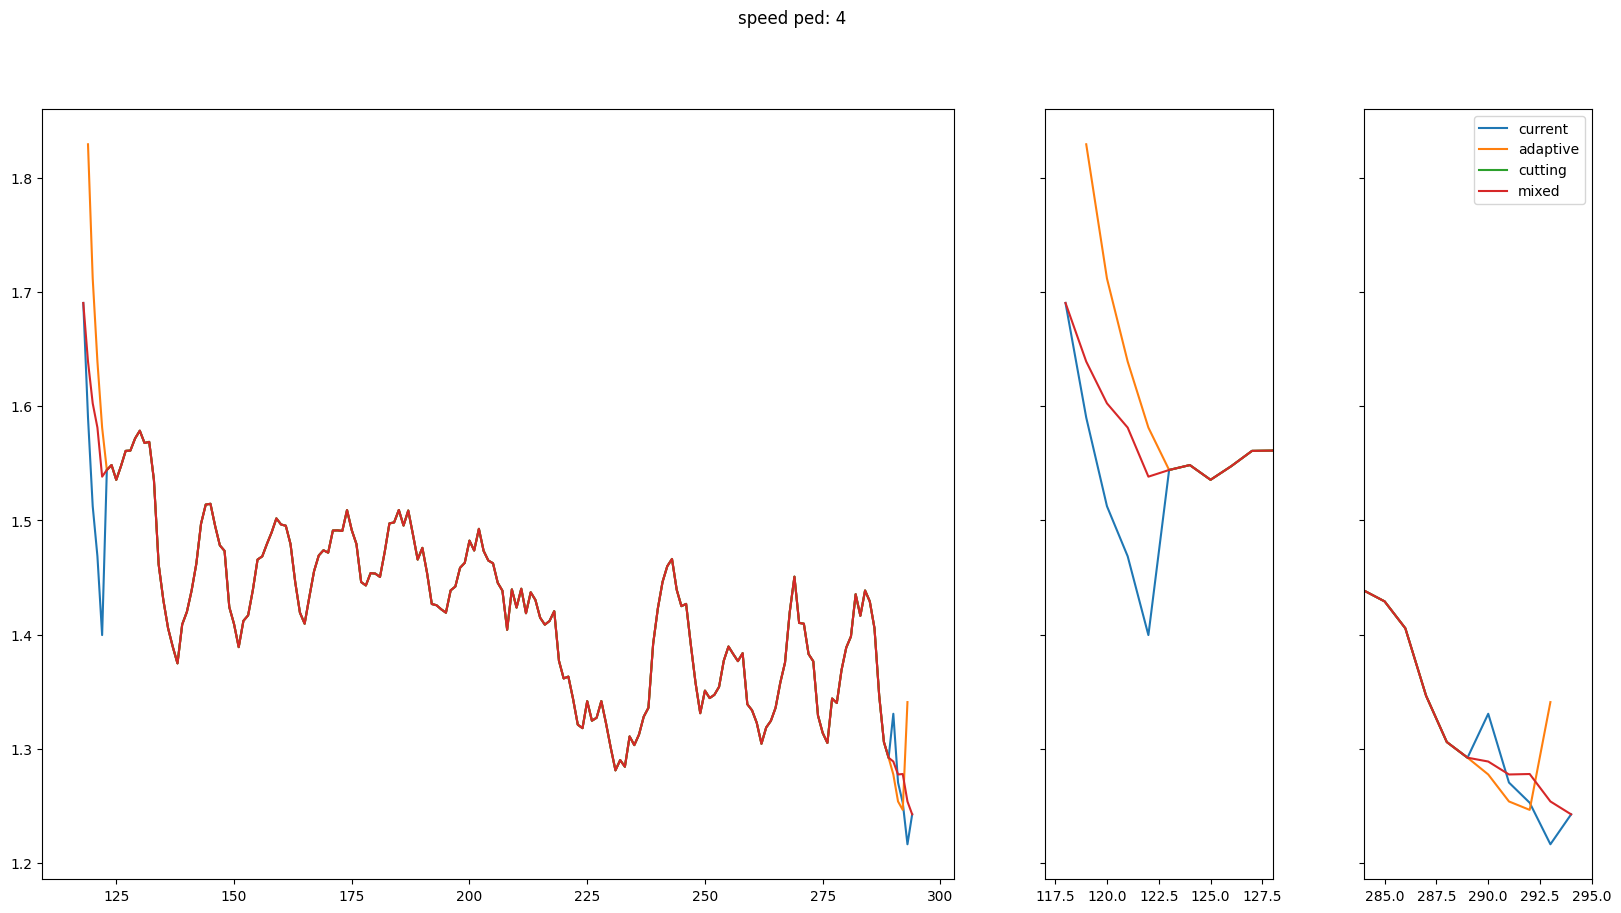

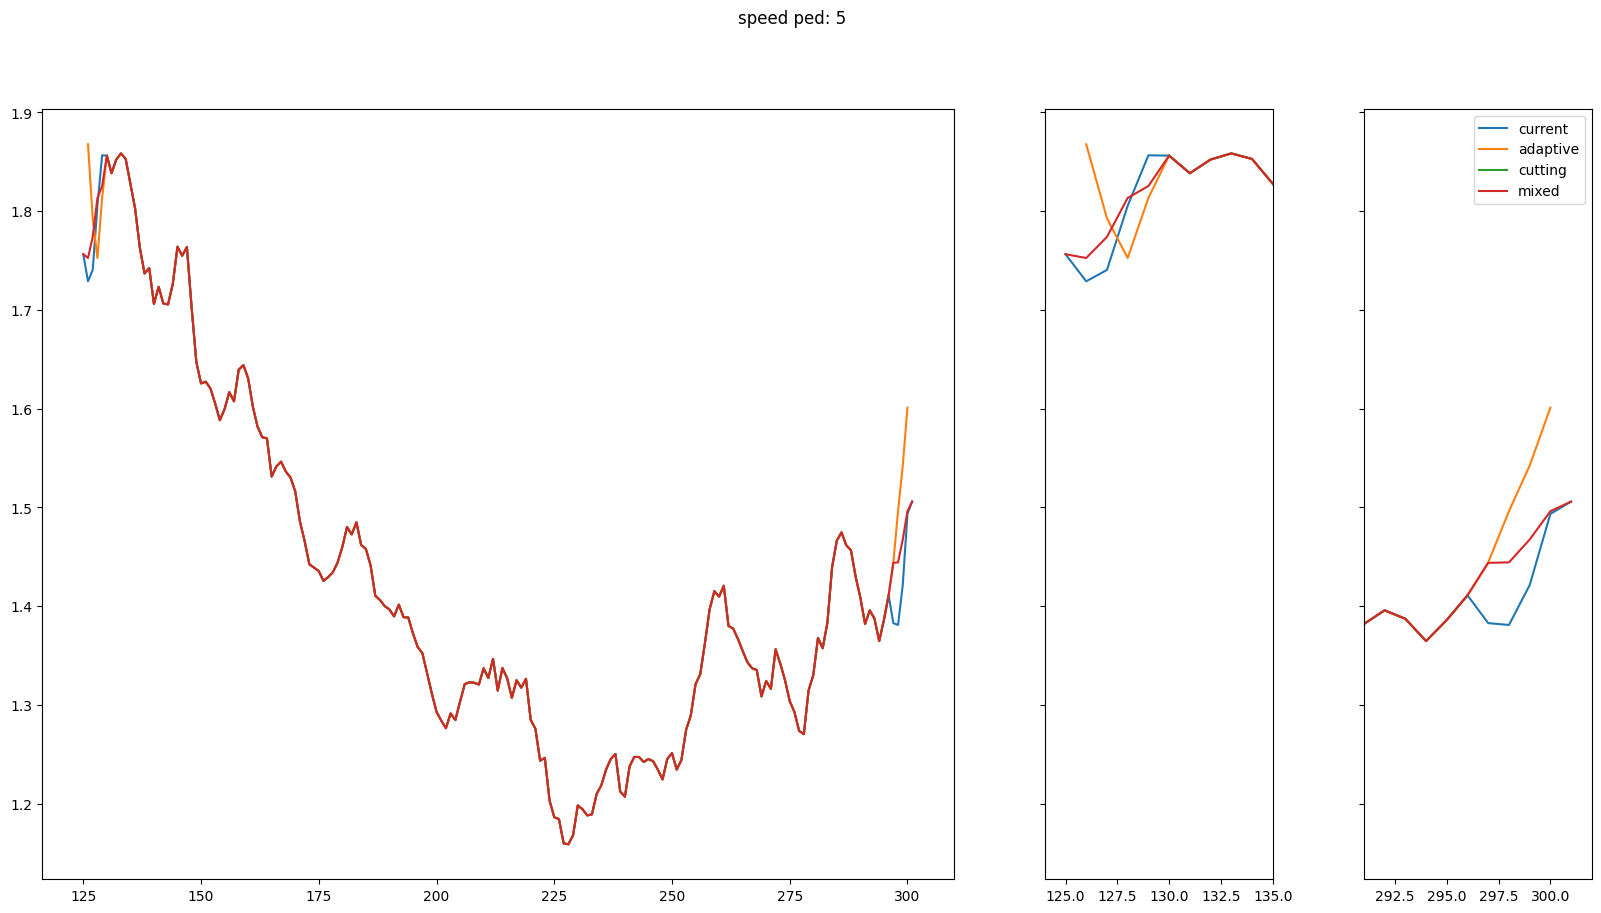

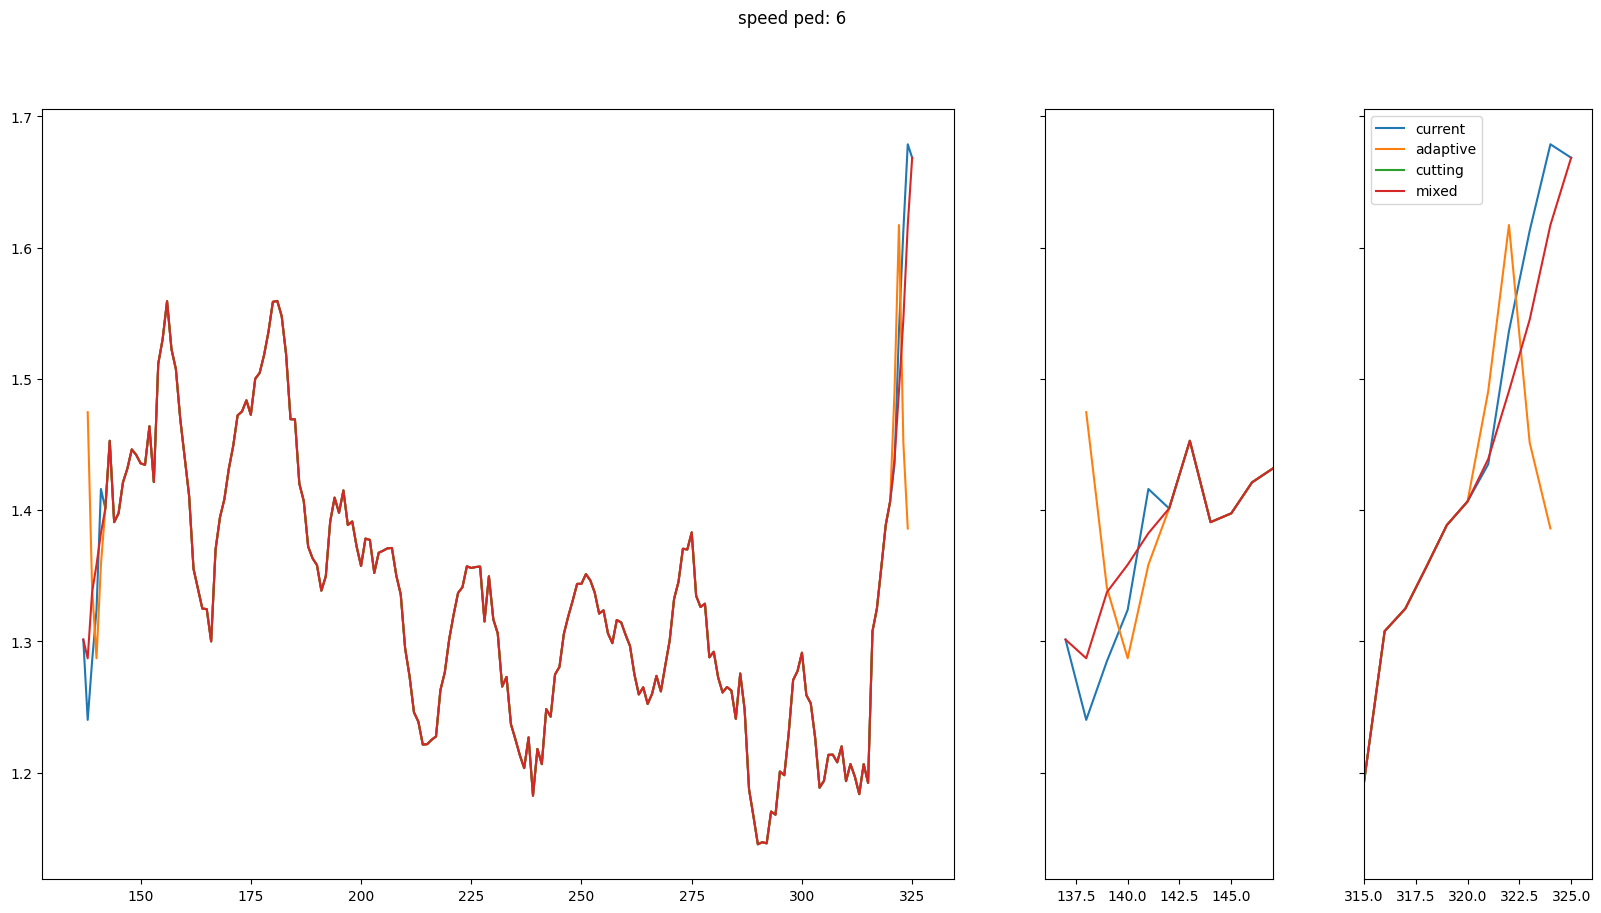

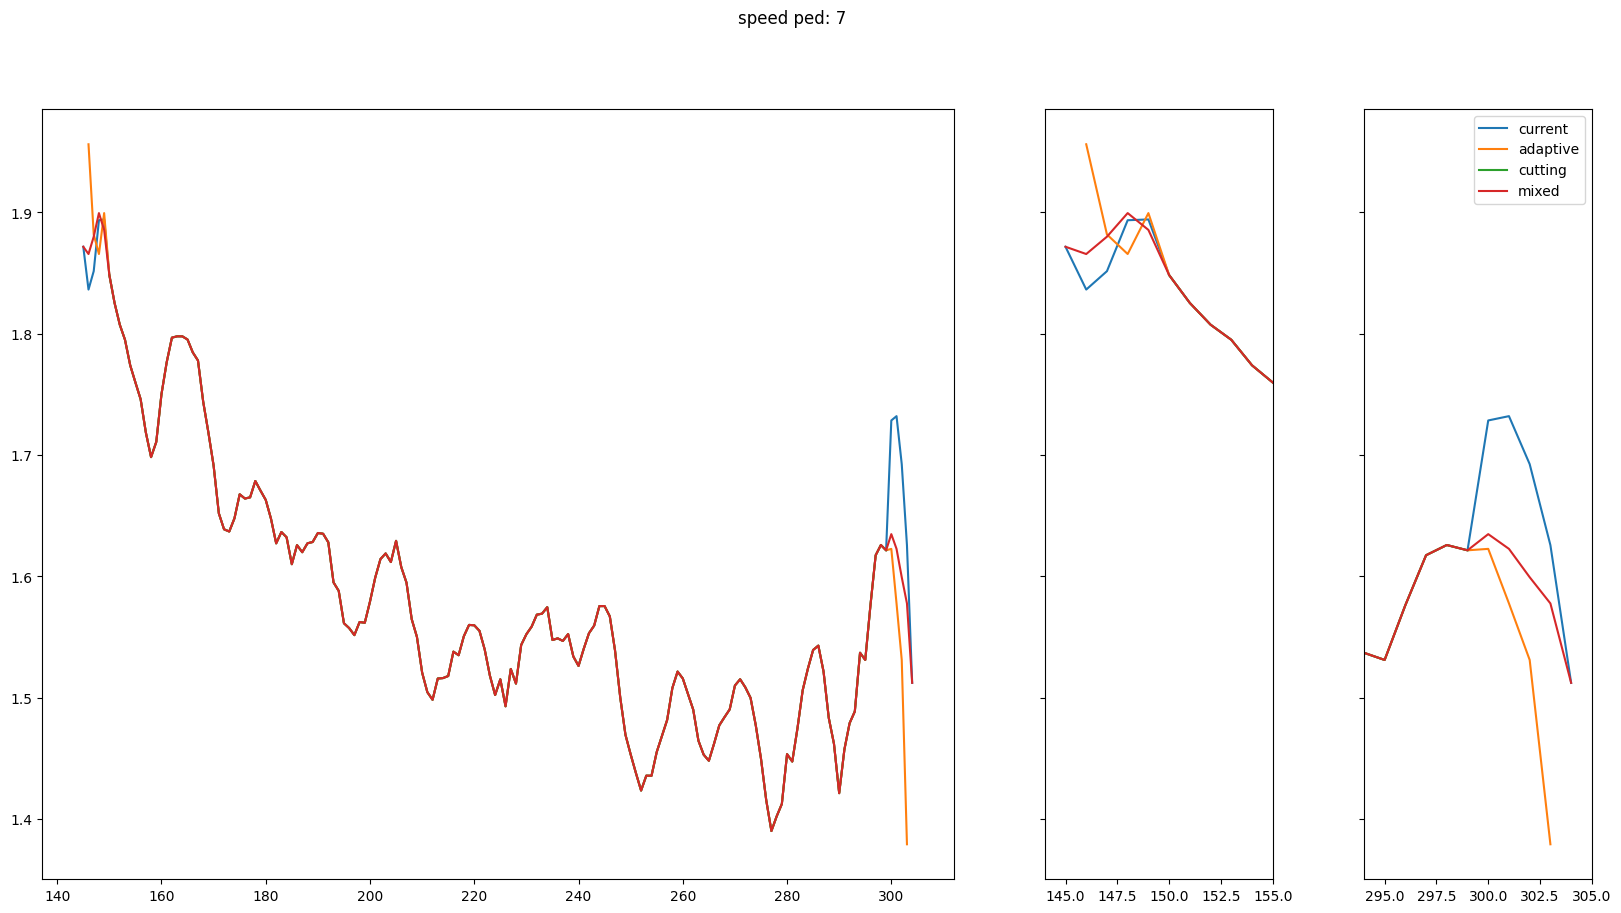

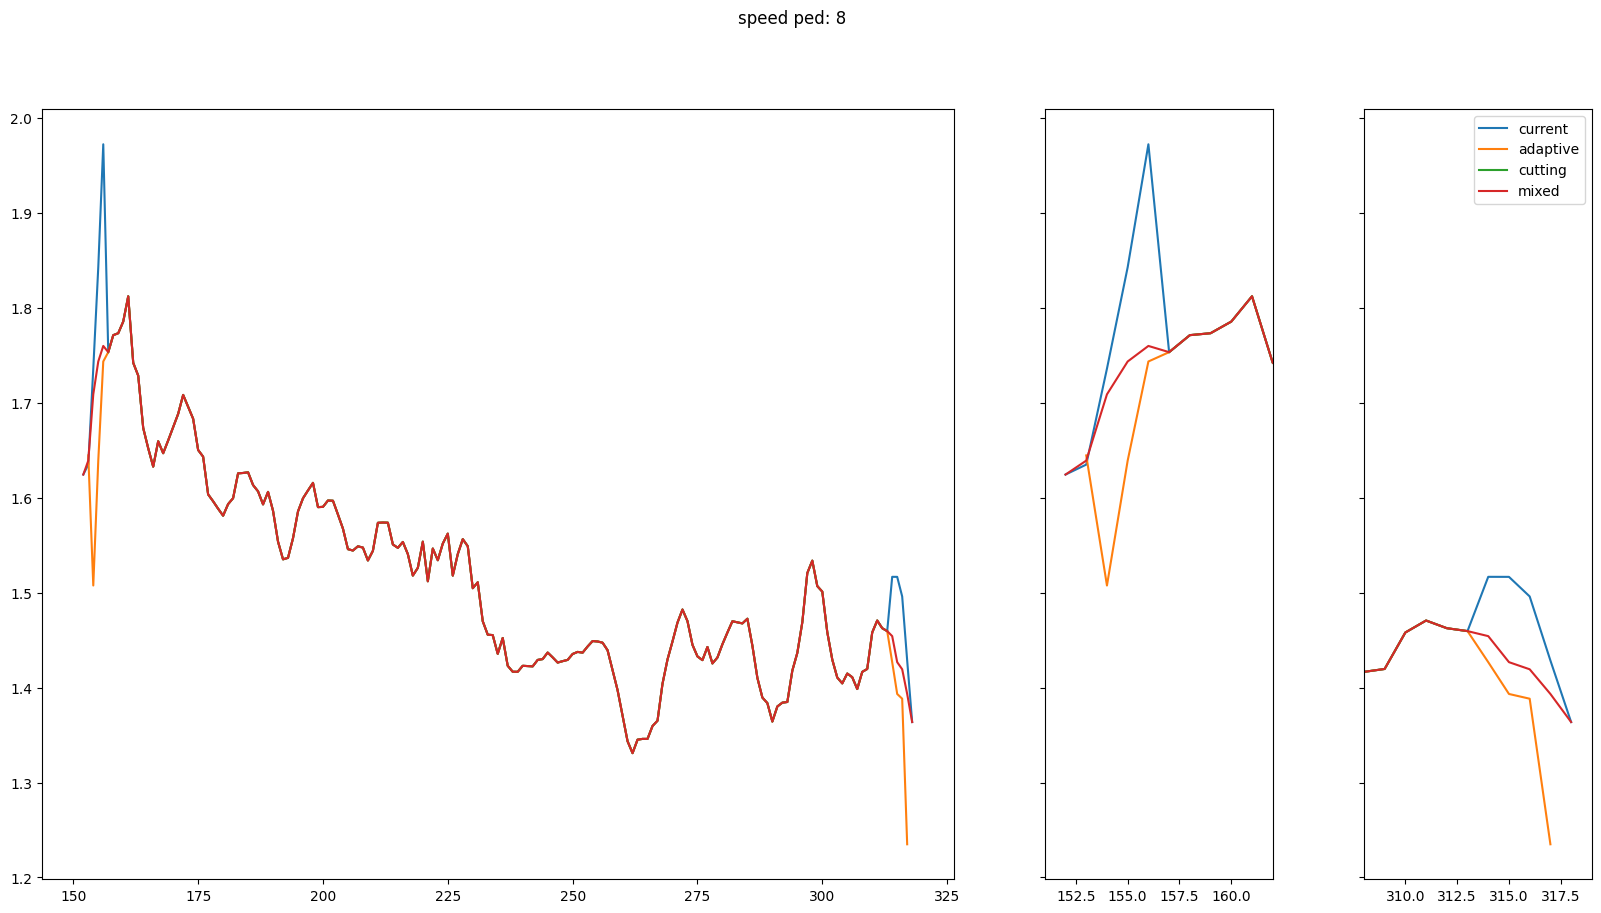

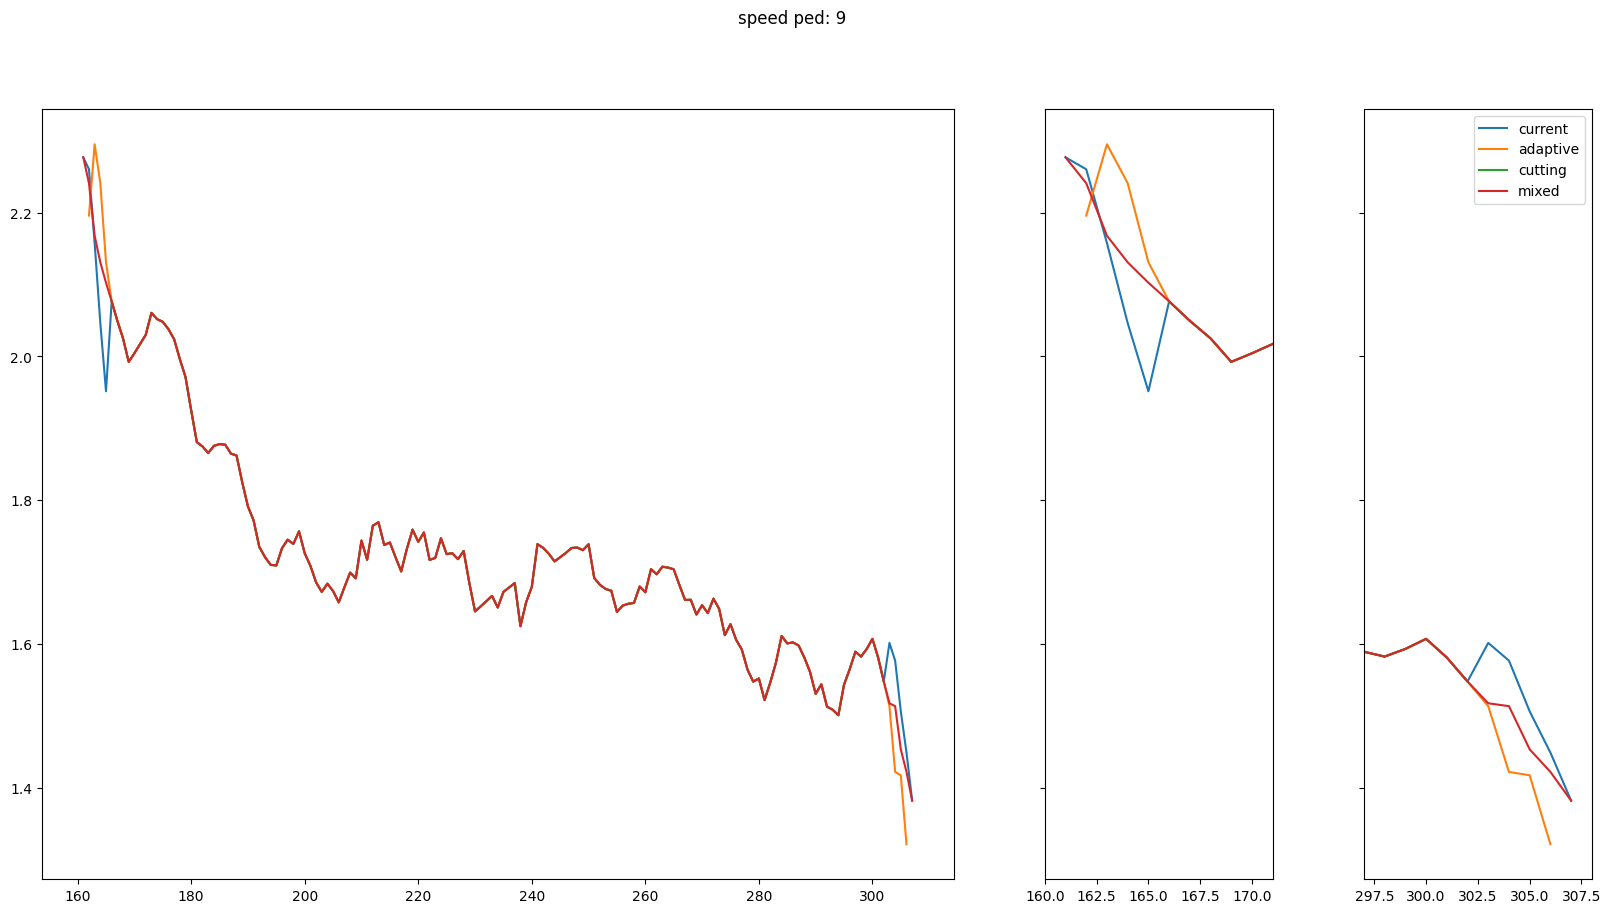

In [13]:
ids = range(1, 10)

for ped_id in ids:
    fig, axs = plt.subplots(
        1, 3, figsize=(20, 10), width_ratios=[8, 2, 2], sharey=True
    )
    fig.suptitle(f"speed ped: {ped_id}")
    axs[0].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[0].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[0].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[0].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    # axs[0].legend()

    axs[1].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[1].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[1].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[1].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    axs[1].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.min() - 1,
            traj.data[traj.data.ID == ped_id].frame.min() + 2 * frame_step,
        ]
    )

    axs[2].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[2].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[2].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[2].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    axs[2].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.max() - 2 * frame_step,
            traj.data[traj.data.ID == ped_id].frame.max() + 1,
        ]
    )
    plt.legend()

# Enhanced comparison

## Computation

Compute the movement and speed for different frame steps with the different methods

In [16]:
frame_steps = [5, 10, 15, 25, 50]

mixed = {}
adaptive = {}
current = {}

mixed_speed = {}
adaptive_speed = {}
current_speed = {}

for frame_step in frame_steps:
    mixed[frame_step] = _compute_individual_movement(
        traj_data=traj.data,
        frame_step=frame_step,
        border_method=VelocityBorderMethod.MAXIMUM_RANGE,
        bidirectional=True,
    )
    mixed_speed[frame_step] = _compute_individual_speed(
        movement_data=mixed[frame_step], frame_rate=traj.frame_rate
    )

    adaptive[frame_step] = _compute_individual_movement(
        traj_data=traj.data,
        frame_step=frame_step,
        border_method=VelocityBorderMethod.ADAPTIVE,
        bidirectional=True,
    )
    adaptive_speed[frame_step] = _compute_individual_speed(
        movement_data=adaptive[frame_step], frame_rate=traj.frame_rate
    )

    current[frame_step] = _compute_individual_movement(
        traj_data=traj.data,
        frame_step=frame_step,
        border_method=VelocityBorderMethod.SINGLE_SIDED,
        bidirectional=True,
    )
    current_speed[frame_step] = _compute_individual_speed(
        movement_data=current[frame_step], frame_rate=traj.frame_rate
    )

### Plots

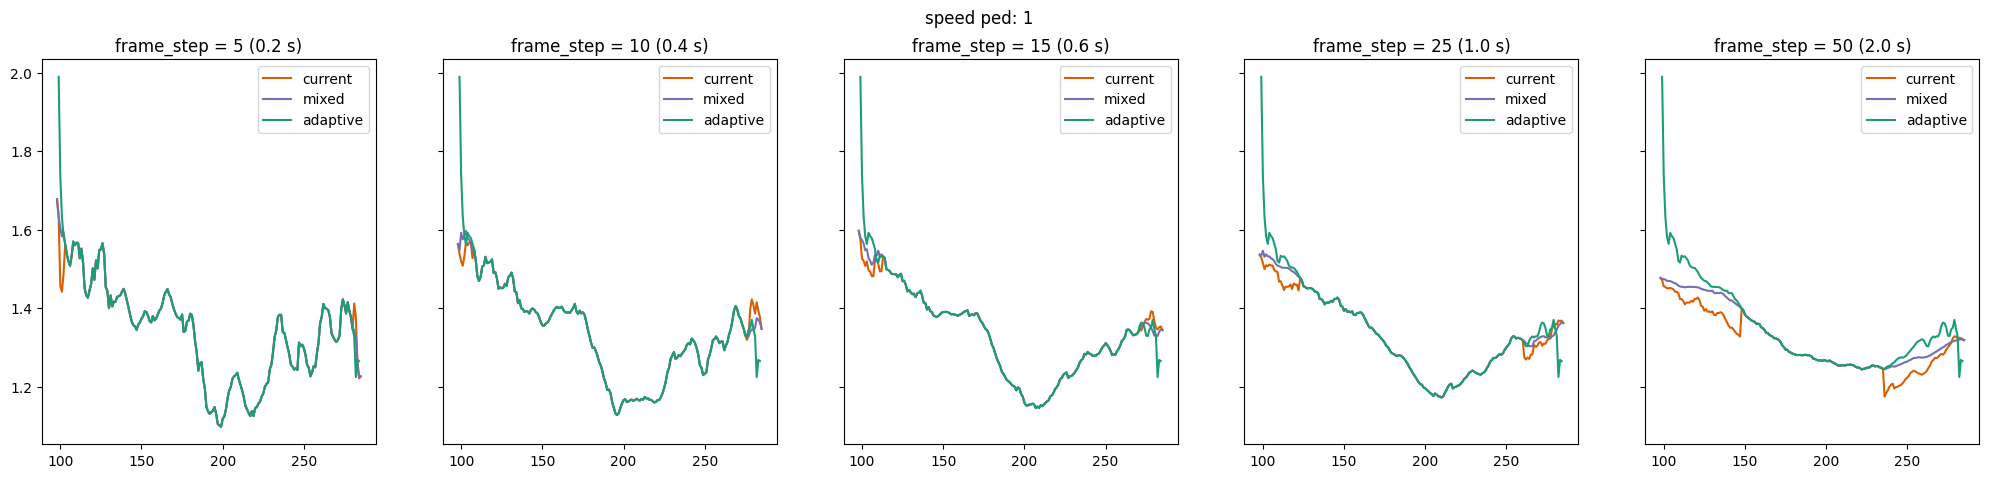

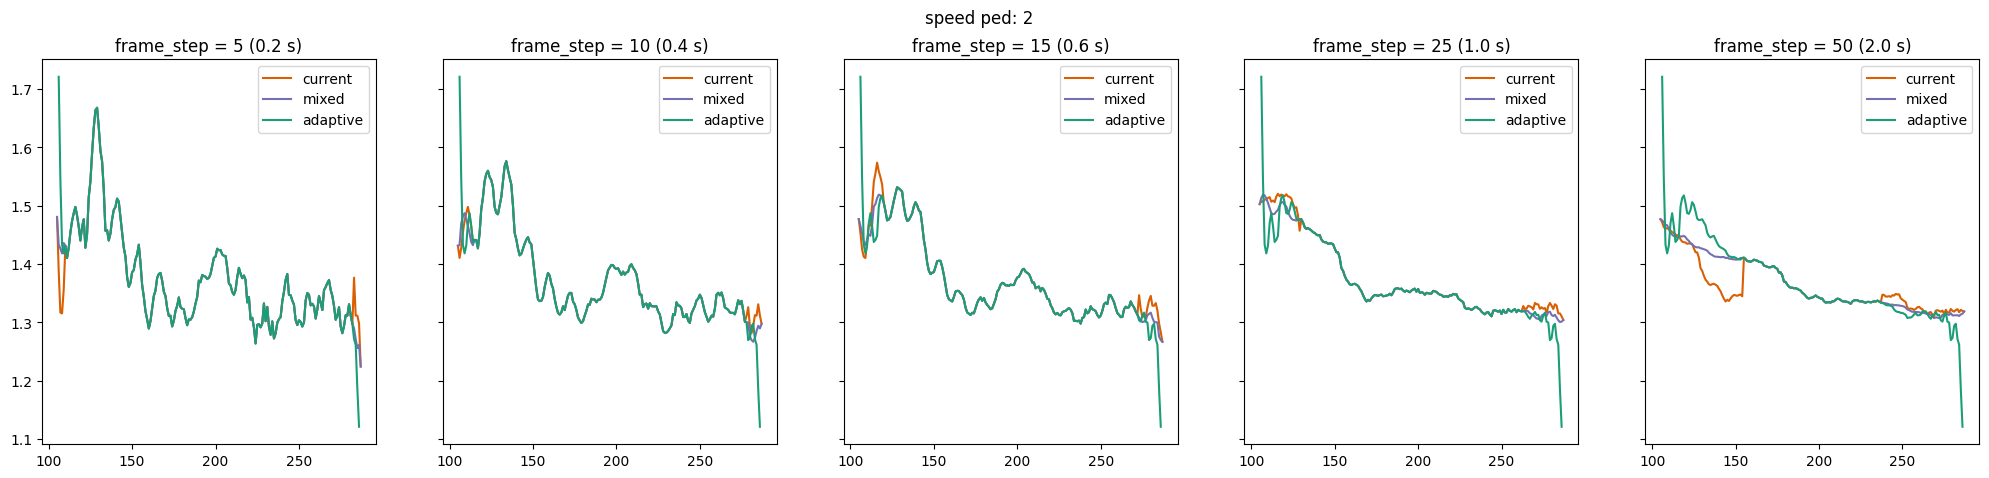

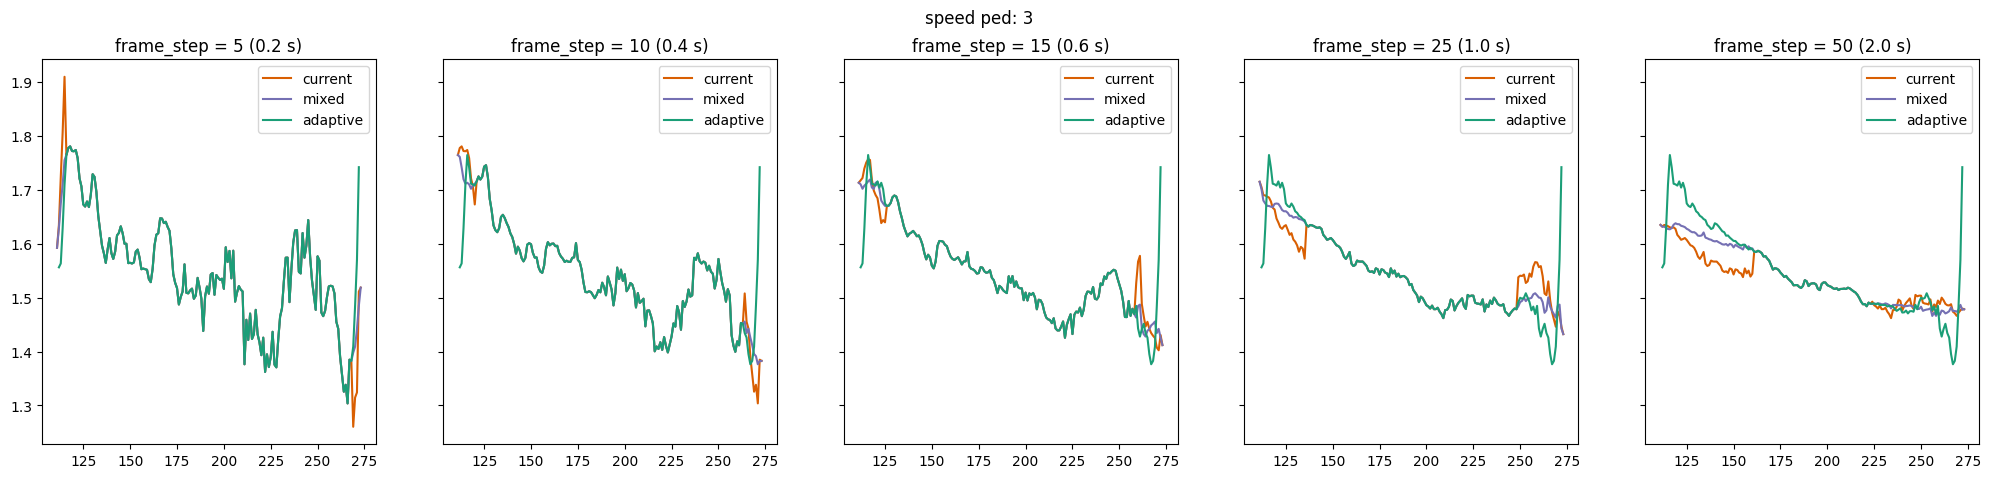

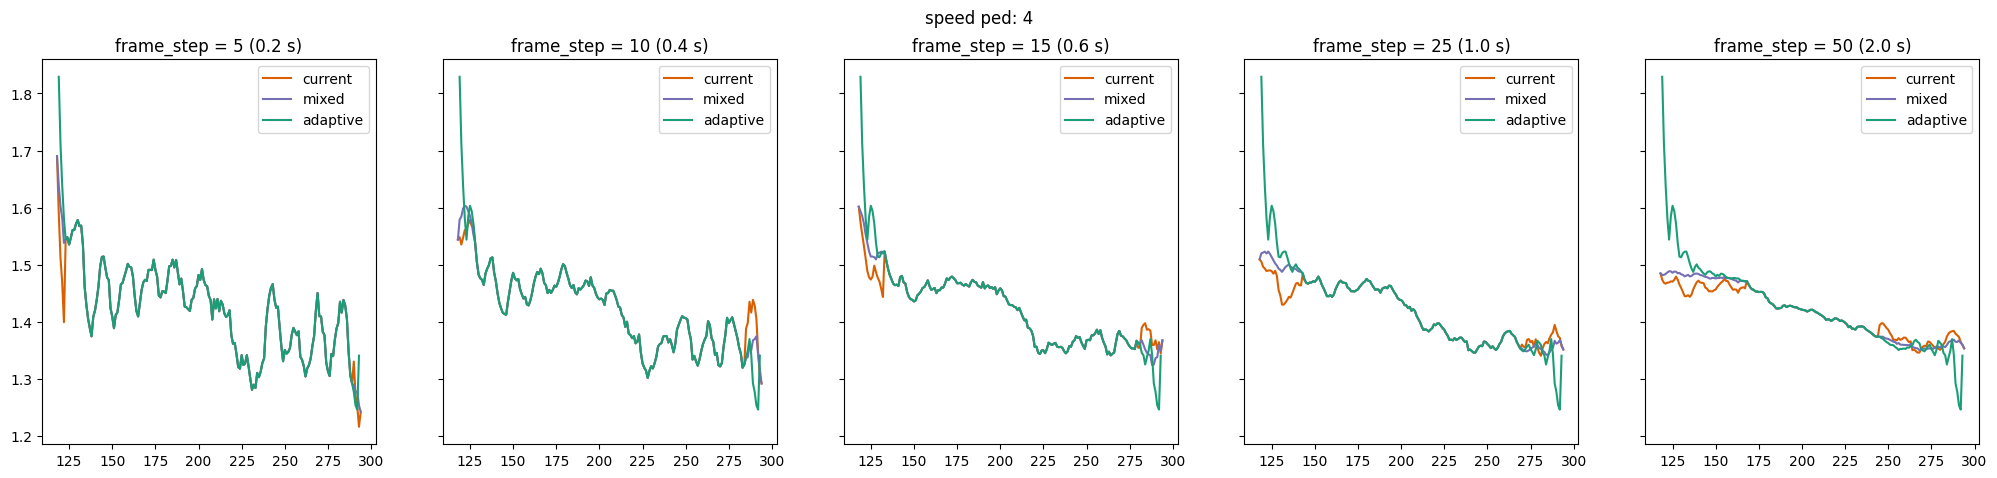

In [17]:
ids = range(1, 5)

for ped_id in ids:
    fig, axs = plt.subplots(
        1, len(current_speed.keys()), figsize=(25, 5), sharey=True
    )
    fig.suptitle(f"speed ped: {ped_id}")

    for ax, fs in zip(axs, current_speed.keys()):
        ax.set_title(f"frame_step = {fs} ({fs/traj.frame_rate} s)")
        current_speed_data = current_speed[fs]
        ax.plot(
            current_speed_data[current_speed_data.ID == ped_id].frame,
            current_speed_data[current_speed_data.ID == ped_id].speed,
            label=f"current",
            color="#d95f02",  #'red',
        )

        mixed_speed_data = mixed_speed[fs]
        ax.plot(
            mixed_speed_data[mixed_speed_data.ID == ped_id].frame,
            mixed_speed_data[mixed_speed_data.ID == ped_id].speed,
            label=f"mixed",
            color="#7570b3",  #'green',
        )

        adaptive_speed_data = adaptive_speed[fs]
        ax.plot(
            adaptive_speed_data[adaptive_speed_data.ID == ped_id].frame,
            adaptive_speed_data[adaptive_speed_data.ID == ped_id].speed,
            label=f"adaptive",
            color="#1b9e77",  #'blue',
        )
        ax.legend()